# Analyze output of .hdf5 files of hadrons code
June 12, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

In [2]:
import subprocess as sp
import os 
import glob
import pandas as pd
import itertools

In [3]:
import gvar as gv
import h5py

In [4]:
%matplotlib notebook

m_f = 0.02 \
Want m_res < 10^-3

$ m_{phys} = m_f + m_{res} $ 

In [5]:
def f_extract_wilson_flow(fname):
    
    keys=['flow_time','Plaq_density','Clover_density','top_charge','plaq','rect','r_ploop','i_ploop']
    flow_vars=dict.fromkeys(keys)

    with h5py.File(fname) as hf:
        for idx,key in enumerate(keys):
            print(type(hf['FlowObservables']['FlowObservables_%s'%(idx)]['data']))
            flow_vars[key]=np.array(hf['FlowObservables']['FlowObservables_%s'%(idx)]['data'])
    
    return flow_vars


## Hadrons code results

In [6]:

fname='/usr/WS2/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_aug31_su3_wflow_comparison/runs/meas1_compare_wflow_su3/090123_120747-tioga/Wflow_.144.h5'


In [7]:
flow_vars=f_extract_wilson_flow(fname)

<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>
<class 'h5py._hl.dataset.Dataset'>


<IPython.core.display.Javascript object>


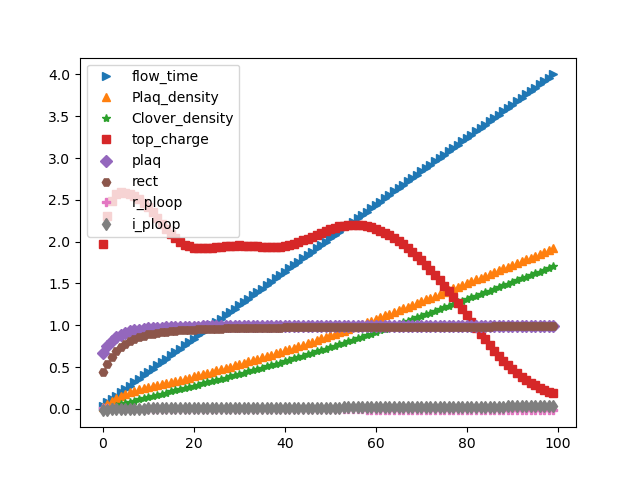

In [8]:
# Plot Wilson flow results

keys=['flow_time','Plaq_density','Clover_density','top_charge','plaq','rect','r_ploop','i_ploop']

plt.figure()
for key,marker in zip(keys,itertools.cycle('>^*sDHPdpx_')):
    plt.plot(flow_vars[key],linestyle='',marker=marker,label=key)
    
plt.legend(loc='best')

## Oliver's Wflow code

In [9]:
f2='/usr/WS2/lsd/ayyar1/projects/SU4_sdm/runs_Grid/2023_aug31_su3_wflow_comparison/runs/meas1_compare_wflow_su3/gauge_configs/config1/WilsonFlow_144_0.04.out'

In [10]:
def f_get_df_wflow(strg,f2):
    
    cmd='grep "{0}" {1}'.format(strg,f2)
    op=sp.check_output(cmd,shell=True).decode().split('\n') # decode bytes to string and split by newlines
    op=[i for i in op if i] # Drop null string

    df=pd.DataFrame([])
    
    for t in op:  
        dict1={}
        a1=t.split(' ')
        a1=[i for i in a1 if i] # Drop null strings

        for i in range(1,len(a1),2):
            # First entry is string name, drop it.
            # Then jump in steps of 2 to get observable name and value
            dict1[a1[i]]=a1[i+1]
    #     print(dict1)
        df=pd.concat([df,pd.DataFrame(dict1,index=[df.shape[0]+1])])
    
    
    return df

df1=f_get_df_wflow('^wflowX',f2) # the ^ is to catch only when occuring at the start of the sentence
df2=f_get_df_wflow('^wflowP',f2)
df3=f_get_df_wflow('^WFLOW',f2)
# df.astype(np.float128)

# df1.merge(df2,on=['t','n','step'],how='inner',suffixes=('_1','_2'))

df_merged=reduce(lambda a,b: pd.merge(a,b,on=['t','n','step'],how='inner'), [df1,df2,df3])

In [11]:
df_merged

,t,n,step,t_P,s_P,t_R,s_R,t_E,s_E,polyXre,...,polyTre,polyTim,action,t2P,P,R,t2E,E,Q,Q2
0,0.00000,0,0.00000,5.6616099321946611e-01,5.6832469794718521e-01,3.2772359216485725e-01,3.3068268857248179e-01,2.2676138213810457e+00,2.2622025999514115e+00,4.7937168967936298e-03,...,7.2567443577641133e-03,-8.1074607113567742e-03,2.5525055584666051e+05,0.0000000000000000e+00,5.6724284558332561e-01,3.2920314036866949e-01,0.0000000000000000e+00,2.2649082106662286e+00,1.5674909788,715.2540783585
1,0.04000,1,0.04000,6.7292712226571538e-01,6.7475638871335386e-01,4.3681633252471752e-01,4.3971432268021160e-01,2.1388732486575677e+00,2.1322269918939352e+00,9.7668383744972560e-03,...,7.3618032868161881e-03,-8.3180837991773202e-03,1.9237596041014075e+05,1.0781468087832555e-03,6.7384175548953462e-01,4.3826532760246456e-01,3.4168801924412025e-03,2.1355501202757514e+00,1.9822427154,638.9085673120
2,0.08000,2,0.04000,7.5445659696441414e-01,7.5591960822775250e-01,5.3591598451323974e-01,5.3849173291529417e-01,1.9563677102359234e+00,1.9480479205770753e+00,1.4465211798998736e-02,...,6.8991689864378010e-03,-7.5176702761152779e-03,1.4439593257436785e+05,4.8332038566149338e-03,7.5518810259608338e-01,5.3720385871426701e-01,1.2494130018601595e-02,1.9522078154064992e+00,2.3046370877,538.4596728687
3,0.12000,3,0.04000,8.1427762659456837e-01,8.1540331675668987e-01,6.1942225767068815e-01,6.2153375024304802e-01,1.7553855814040091e+00,1.7452779708599078e+00,1.7546122865559819e-02,...,6.2609710976726874e-03,-6.0898068466632106e-03,1.0921153363439375e+05,1.1733702792129059e-02,8.1484047167562912e-01,6.2047800395686814e-01,2.5204777576300200e-02,1.7503317761319583e+00,2.4910118218,438.7472169197
4,0.16000,4,0.04000,8.5746881479829684e-01,8.5830331269372151e-01,6.8682711309885580e-01,6.8843326471468458e-01,1.5601531554396946e+00,1.5483831106494068e+00,1.8965112273141693e-02,...,5.7074303712788691e-03,-4.3907414726756730e-03,8.3822210337073833e+04,2.1961883231897836e-02,8.5788606374600918e-01,6.8763018890677019e-01,3.9789264205940499e-02,1.5542681330445507e+00,2.5704774001,352.9694954823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,3.84000,96,0.04000,9.9661654965111268e-01,9.9648146117129222e-01,9.8731072790154828e-01,9.8678684079370038e-01,1.1421339161083016e-01,1.0582803458247481e-01,2.7002765884502011e-02,...,-1.6113449074043055e-02,3.1885558392789538e-02,2.0354794323430101e+03,1.4694713014191423e+01,9.9654900541120228e-01,9.8704878434762433e-01,1.6223214270379989e+00,1.1002071309665248e-01,0.2824943079,12.1730634615
97,3.88000,97,0.04000,9.9664588586143310e-01,9.9651209581444022e-01,9.8741481854814517e-01,9.8689647000855629e-01,1.1332424864417469e-01,1.0498368481943983e-01,2.6456292401247295e-02,...,-1.6404476757012385e-02,3.2252982689234412e-02,2.0177933080048438e+03,1.5002898759670632e+01,9.9657899083793666e-01,9.8715564427835067e-01,1.6432474767673193e+00,1.0915396673180727e-01,0.2546868121,12.0304147157
98,3.92000,98,0.04000,9.9667450797631019e-01,9.9654200147115135e-01,9.8751662391155159e-01,9.8700378661064292e-01,1.1245141661270153e-01,1.0415663031404457e-01,2.5911583120887722e-02,...,-1.6694812945421512e-02,3.2622085547633364e-02,2.0005327658304145e+03,1.5314281085386735e+01,9.9660825472373071e-01,9.8726020526109715e-01,1.6642429461475758e+00,1.0830402346337306e-01,0.2295993702,11.8899626080
99,3.96000,99,0.04000,9.9670243541411074e-01,9.9657119966973673e-01,9.8761620094685698e-01,9.8710885265510429e-01,1.1159449786428663e-01,1.0334645587300459e-01,2.5369038258273857e-02,...,-1.6984283660736819e-02,3.2992849531848951e-02,1.9836857301524365e+03,1.5628859917965430e+01,9.9663681754192368e-01,9.8736252680098047e-01,1.6853090300633529e+00,1.0747047686864561e-01,0.2069072848,11.7518984323


In [12]:
flow_vars.keys()
# flow_vars['r_ploop']

dict_keys(['flow_time', 'Plaq_density', 'Clover_density', 'top_charge', 'plaq', 'rect', 'r_ploop', 'i_ploop'])

In [13]:
df_merged.columns

Index(['t', 'n', 'step', 't_P', 's_P', 't_R', 's_R', 't_E', 's_E', 'polyXre',
       'polyXim', 'polyYre', 'polyYim', 'polyZre', 'polyZim', 'polyTre',
       'polyTim', 'action', 't2P', 'P', 'R', 't2E', 'E', 'Q', 'Q2'],
      dtype='object')

In [14]:
# print('{:.3e}'.format(0.223))
# f"{0.0003509:.2E}"


In [15]:
# flow_vars['plaq'],df_merged.s_P.values[1:]

flow_vars['plaq'],df_merged.s_P.values[1:]

def f_compare_values(c1,c2,plot=False):
    
    assert c1 in flow_vars.keys(),"%s not in %s"%(c1,flow_vars.keys())
    assert c2 in df_merged.columns, "%s not in %s"%(c2,df_merged.columns)
    a1=flow_vars[c1]
    a2=df_merged[c2].values[1:]

    print('Labels \t%s\t%s\n'%(c1,c2))
    for i in range(len(a1)):
        if np.abs(float(a1[i])-float(a2[i]))>1e-15:
#         if True:
            print(i,f"{a1[i]:.18e}",a2[i],float(a1[i])-float(a2[i]))
        
        
    
    if plot:
        plt.figure()
#         plt.plot(a1,color='blue',linestyle='',marker='H')
#         plt.plot(a2.astype(float),color='yellow',linestyle='',marker='*')
        plt.plot(np.abs(a1-a2.astype(float)),linestyle='',marker='x')
        plt.ylabel('Deviation between the two approaches')
#         plt.xlabel('Wflow time')
        

## Perfect matches

Labels 	r_ploop	polyTre



<IPython.core.display.Javascript object>


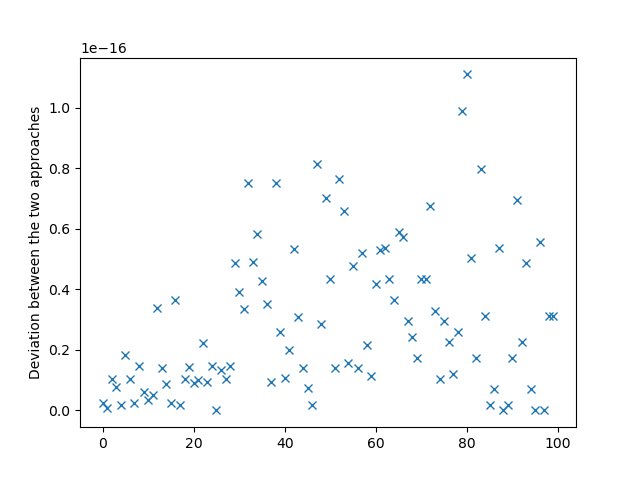

In [16]:
        
f_compare_values('r_ploop','polyTre',True)
plt.savefig('polyTre.pdf')
# f_compare_values('i_ploop','polyTim')
# f_compare_values('plaq','P')
# f_compare_values('rect','R',True)

## Mismatch

In [17]:
# f_compare_values('plaq','t_P')
# f_compare_values('Clover_density','t_E')
# f_compare_values('rect','s_R')

Labels 	Clover_density	t2E

0 3.433535569160378262e-03 3.4168801924412025e-03 1.6655376719175788e-05
1 1.252582054056944165e-02 1.2494130018601595e-02 3.1690521967846566e-05
2 2.523973271083903083e-02 2.5204777576300200e-02 3.495513453883117e-05
3 3.982120127453404185e-02 3.9789264205940499e-02 3.193706859354328e-05
4 5.508924661656629945e-02 5.5062139628102663e-02 2.7106988463636295e-05
5 7.038185229614173088e-02 7.0359380089735191e-02 2.247220640654024e-05
6 8.539416722420184458e-02 8.5375514984187981e-02 1.8652240013863897e-05
7 1.000310546053964217e-01 1.0001536001833379e-01 1.569458706263127e-05
8 1.143051498007544714e-01 1.1429168655165146e-01 1.3463249103007335e-05
9 1.282753462496055152e-01 1.2826355852402879e-01 1.1787725576722918e-05
10 1.420133030822288422e-01 1.4200278945169714e-01 1.0513630531699958e-05
11 1.555873478965349721e-01 1.5557782937192205e-01 9.518524612922574e-06
12 1.690562002719865342e-01 1.6904748812861783e-01 8.712143368699854e-06
13 1.824675565551908962e-0

<IPython.core.display.Javascript object>


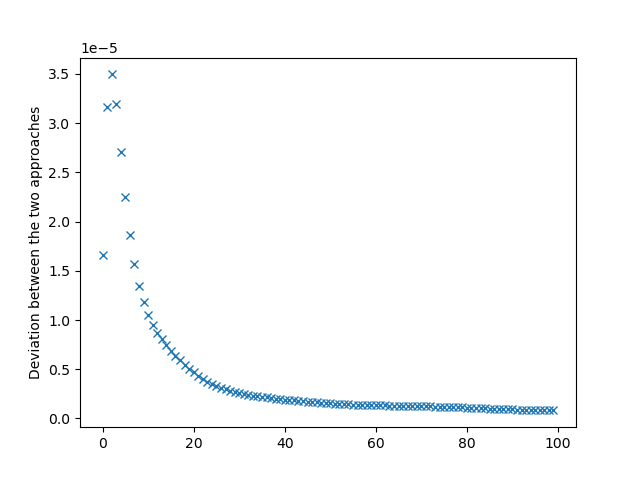

In [18]:
# f_compare_values('Clover_density','t_E')
# f_compare_values('Clover_density','s_E')
# f_compare_values('Clover_density','E')

f_compare_values('Clover_density','t2E',True)
plt.savefig('clover_t2E.pdf')

In [20]:
f_compare_values('Plaq_density','s_P')

Labels 	Plaq_density	s_P

0 1.878671488380279433e-02 6.7475638871335386e-01 -0.6559696738295511
1 5.640466116186234474e-02 7.5591960822775250e-01 -0.6995149470658901
2 9.598669948335374069e-02 8.1540331675668987e-01 -0.7194166172733362
3 1.309722036516776378e-01 8.5830331269372151e-01 -0.7273311090420439
4 1.599526995774824545e-01 8.8921696923646187e-01 -0.7292642696589794
5 1.835676214117796523e-01 9.1166936616865435e-01 -0.7281017447568747
6 2.030303470265749921e-01 9.2818069006482928e-01 -0.7251503430382543
7 2.195352223036827199e-01 9.4050228838986960e-01 -0.7209670660861869
8 2.340655373302990283e-01 9.4984153060762311e-01 -0.7157759932773241
9 2.473653565206657412e-01 9.5703253879595307e-01 -0.7096671822752874
10 2.599698582199835295e-01 9.6265573328039722e-01 -0.7026858750604137
11 2.722498270813938914e-01 9.6711901097116615e-01 -0.6948691838897723
12 2.844532722454424234e-01 9.7071232070480740e-01 -0.6862590484593649
13 2.967394232711217383e-01 9.7364430355887166e-01 -0.6769048

Labels 	top_charge	Q

0 1.977304598783406142e+00 1.9822427154 -0.004938116616593824
1 2.303105531544166418e+00 2.3046370877 -0.0015315561558337798
2 2.491421606960693147e+00 2.4910118218 0.00040978516069323234
3 2.571168200013839389e+00 2.5704774001 0.0006907999138392462
4 2.590616260322711195e+00 2.5903131785 0.00030308182271099326
5 2.583959038984191992e+00 2.5841018811 -0.00014284211580806172
6 2.566318960296945395e+00 2.5667622627 -0.0004433024030547905
7 2.541049338034955696e+00 2.5416357065 -0.0005863684650444512
8 2.507237737262370647e+00 2.5078554728 -0.0006177355376295601
9 2.463779866814582498e+00 2.4643659163 -0.0005860494854172948
10 2.410812376556710213e+00 2.4113397194 -0.000527342843289702
11 2.349934844547378887e+00 2.3503986621 -0.0004638175526210375
12 2.283973285691547339e+00 2.2843798826 -0.0004065969084527943
13 2.216505477013835712e+00 2.2168646929 -0.00035921588616449895
14 2.151260133519693696e+00 2.1515810297 -0.00032089618030628486
15 2.091547071212514375e+00 

<IPython.core.display.Javascript object>


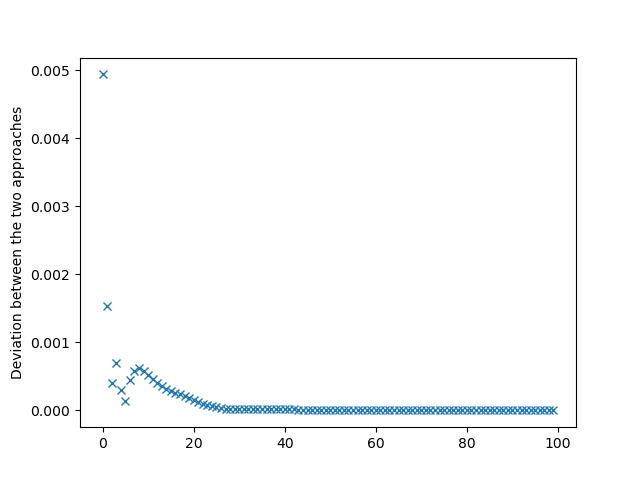

In [21]:
f_compare_values('top_charge','Q',True)
plt.savefig('top_charge.pdf')